# Vehicle Detection Project

This project's goal is to

#1 - Create a classifier that can identify a car
#2 - Create a pipeline that utilizes the classifier to work on images and/or video streams.
#3 - When using video, have the pipeline work with previous known locations of cars to simplify future searches.

In [1]:
#First, load up things we're definitely going to need
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

## Training a classifier

The datasets we're using are provided by Udacity and assumed to have been extracted into the `data/` folder, separated into `vehicle` and `non-vehicle` folders to keep the dataset labelled. For space reasons, they are not included in the repository, but are provided here:

* [Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
* [Non-Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

Here we load up the dataset:

In [2]:
dataset = { "vehicles": [], "nonvehicles": [] }

In [3]:
# Load all of the dataset images
vehicle_dataset_names = [
    "GTI_Far",
    "GTI_Left",
    "GTI_MiddleClose",
    "GTI_Right",
    "KITTI_extracted"
]

non_vehicle_dataset_names = [
    "Extras",
    "GTI"
]

from glob import glob

def get_filenames(folder):
    return glob(folder + "/*.png")

for vehicle_dataset in vehicle_dataset_names:
    dataset['vehicles'] += get_filenames("./data/vehicles/" + vehicle_dataset)
    
for nonvehicle_dataset in non_vehicle_dataset_names:
    dataset['nonvehicles'] += get_filenames("./data/non-vehicles/" + nonvehicle_dataset)


In [4]:
# We need to know if the two datasets are approximately equal before moving on
print("Number of vehicles present in dataset:", len(dataset["vehicles"]))
print("Number of non-vehicles present in dataset:", len(dataset["nonvehicles"]))

Number of vehicles present in dataset: 8792
Number of non-vehicles present in dataset: 8968


We needed to ensure that there were roughly the same number of samples in each vehicle and non-vehicle datasets. Having an imbalance would increase the likelihood that any classifier we created would lean too heavily in just classifying a given input as the majority dataset.

With the above #s, it seems that the culmination of all the datasets provided leads to an approximately equal outcome - we can work with this without having to cull any samples.

Please note that we're loading with OpenCV and then converting to RGB to avoid scaling issues with PNGs.

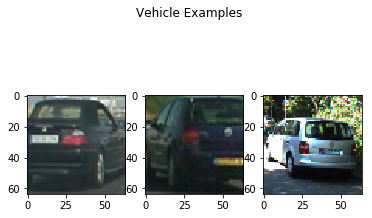

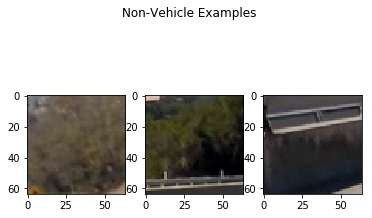

In [5]:
# Load up a couple of random examples of each
from random import randint

example_images_positive = []
example_images_negative = []

fig = plt.figure()
fig.suptitle("Vehicle Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3,i + 1)
    img = cv2.imread(dataset['vehicles'][randint(0, len(dataset['vehicles']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

fig = plt.figure()
fig.suptitle("Non-Vehicle Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3, i + 1)
    img = cv2.imread(dataset['nonvehicles'][randint(0, len(dataset['nonvehicles']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
# Now we have to create a singular features/labels dataset

features = []
labels = []

for data in dataset['vehicles']:
    features.append(data)
    labels.append("vehicle")

for data in dataset['nonvehicles']:
    features.append(data)
    labels.append("nonvehicle")

print(len(features), len(labels))

17760 17760


### Splitting the Dataset

Now that we have the datasets loaded, we need to split them into training and test datasets.

To do this, we'll make use of sklearn's helper functions.

In [7]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_original_labels, test_labels = train_test_split(features, labels, test_size=0.25)

print(len(train_imgs), len(test_imgs), len(test_imgs) / (len(test_imgs) + len(train_imgs)) )

13320 4440 0.25


## Color Histogram

As part of building a car fingerprint, I'll build a color histogram of the car. But what color spaces are useful? Let's explore some of the test images and see what color spaces give us useful information.

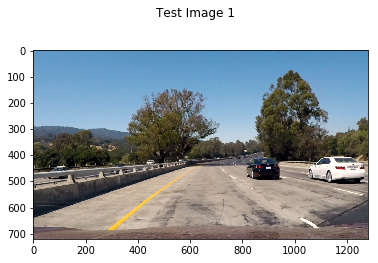

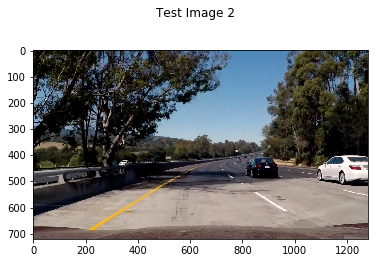

In [8]:
# Load up two test images
test_img1 = cv2.cvtColor(cv2.imread("./test_images/test1.jpg"), cv2.COLOR_BGR2RGB)
test_img2 = cv2.cvtColor(cv2.imread("./test_images/test5.jpg"), cv2.COLOR_BGR2RGB)

plt.figure()
plt.suptitle("Test Image 1")
plt.imshow(test_img1)
plt.show()
plt.figure()
plt.suptitle("Test Image 2")
plt.imshow(test_img2)
plt.show()

### Functionality to Handle 3d Plots

In [9]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(img, colorspace, axis_limits=((0, 255), (0, 255), (0, 255))):
    
    if colorspace is not "RGB":
        colorspace_img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + colorspace))
    else:
        colorspace_img = img
    
    axis_labels = colorspace
    axis_labels = list(axis_labels)
    color_channels = img / 255
    
    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        colorspace_img[:, :, 0].ravel(),
        colorspace_img[:, :, 1].ravel(),
        colorspace_img[:, :, 2].ravel(),
        c=color_channels.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

### RGB Exploration

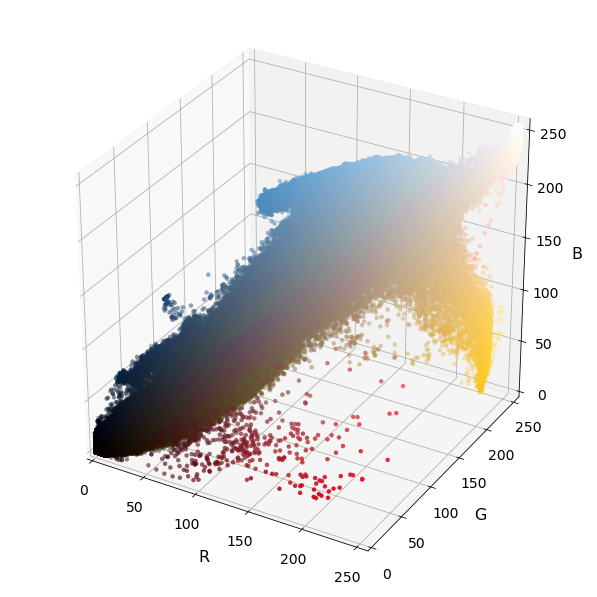

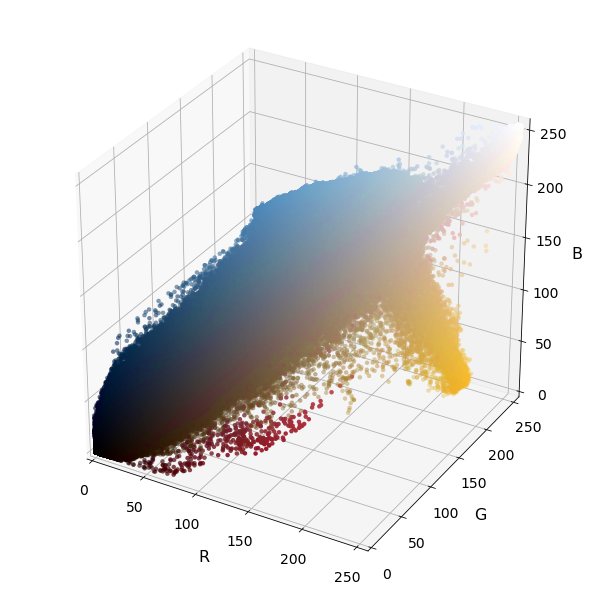

In [11]:
plot3d(test_img1, "RGB")
plot3d(test_img2, "RGB")

### HLS Exploration

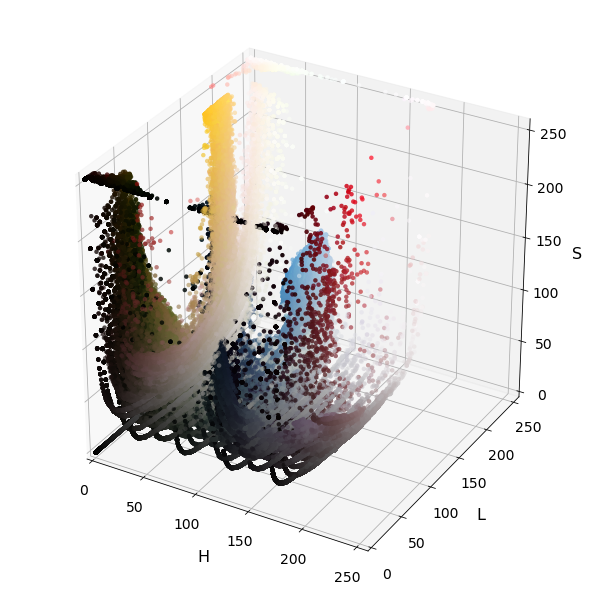

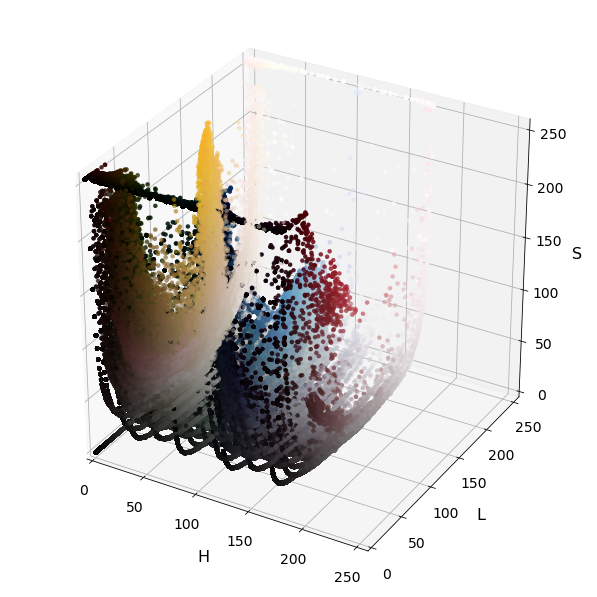

In [12]:
plot3d(test_img1, "HLS")
plot3d(test_img2, "HLS")

### LUV Exploration

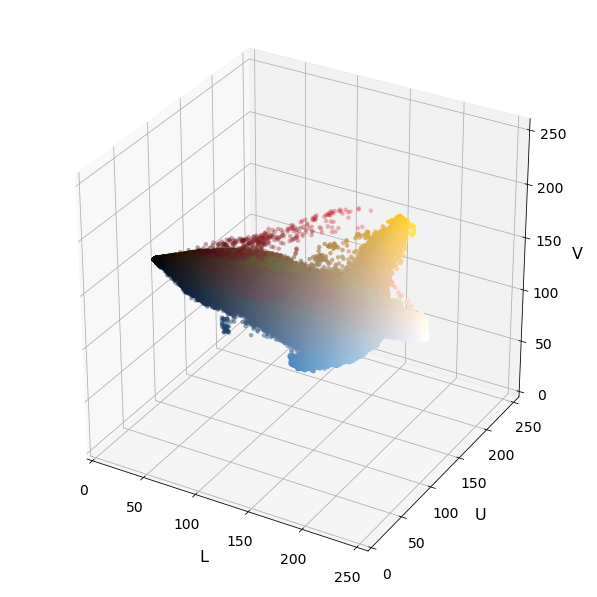

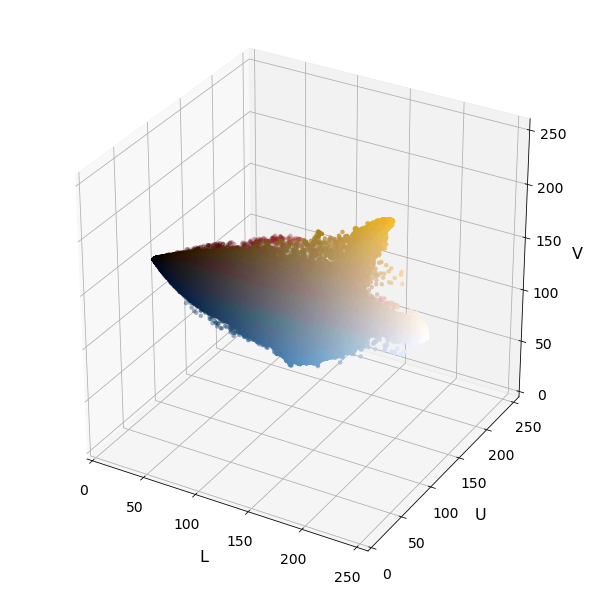

In [13]:
plot3d(test_img1, "LUV")
plot3d(test_img2, "LUV")

### HSV Exploration

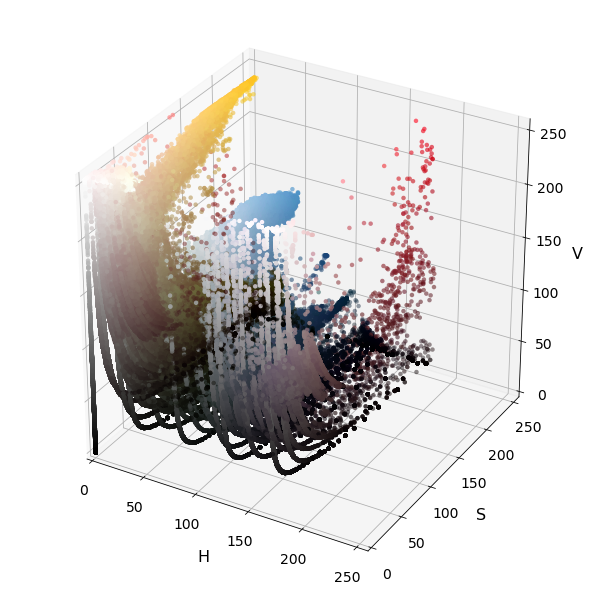

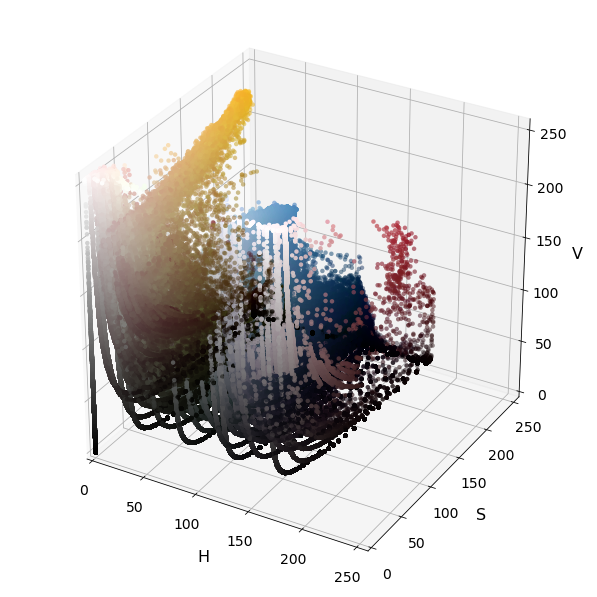

In [14]:
plot3d(test_img1, "HSV")
plot3d(test_img2, "HSV")

### YCrCb

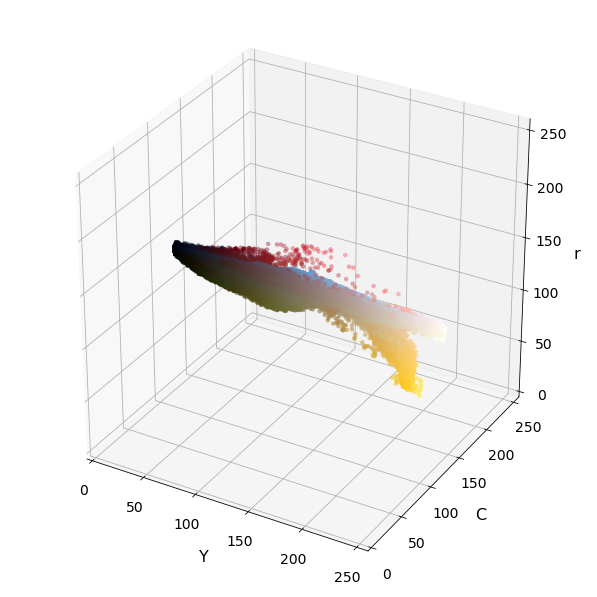

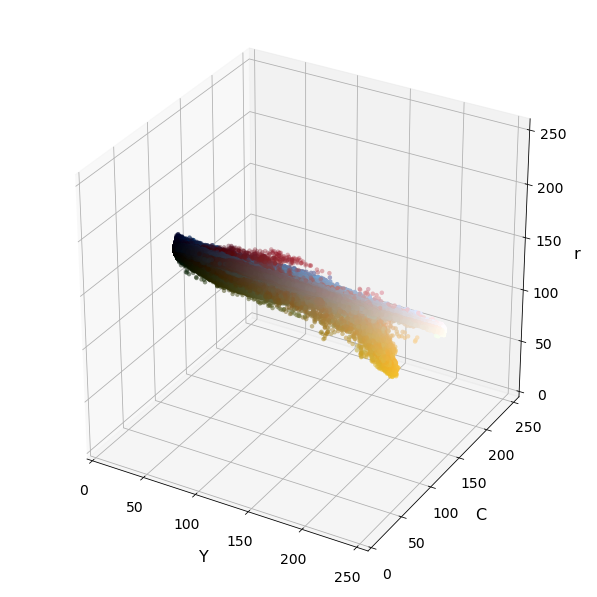

In [15]:
plot3d(test_img1, "YCrCb")
plot3d(test_img2, "YCrCb")

### YUV Exploration

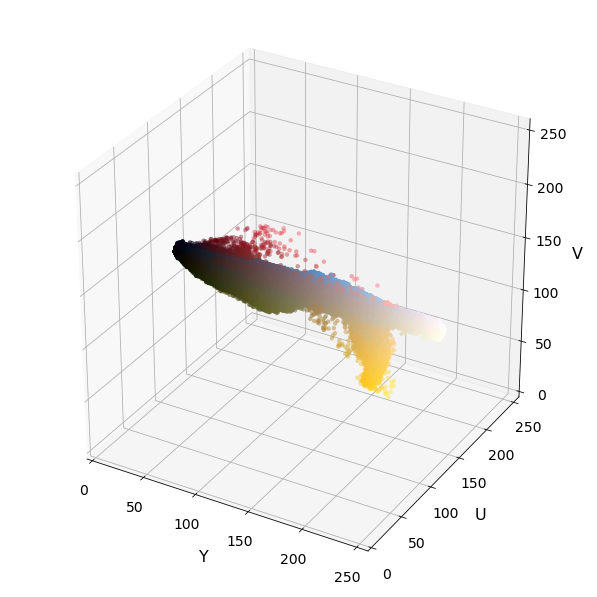

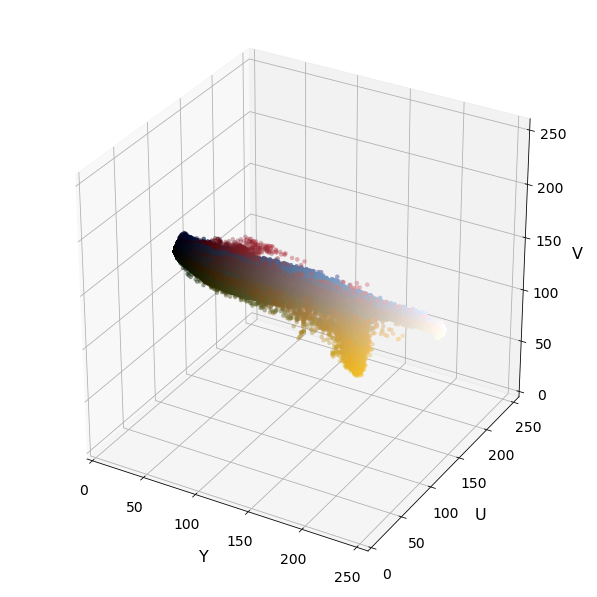

In [16]:
plot3d(test_img1, "YUV")
plot3d(test_img2, "YUV")

### Findings for Color Exploration

Above, I looked at two sample images of two cars each in the RGB, HLS, LUV, and HSV color spaces. The goal was to see what colorspaces, if any, have significantly noticeable separation of pixels related to car relative to surrounding pixels.

RGB LUV, YUV, and YCrCb colorspaces seemed to have the pixels for the images group up too closely to see anything identifiable as a separate entity between car and background.

The HLS color space is definitely identifiable - specifically across the Hue and Lightness channels.

Since it seems that the HSL colorspace is slightly more "separated", we'll use that for dealing with colors.

## Spatial Binning of Color

In order to reduce the amount of features being processed, we're going to create a function that spatically bins the color image. This consists of:

1. If the colorspace requested is not RGB, convert the image to the approrpiate color space
2. Resize the image of the chosen image to a smaller size, like 32x32 pixels
3. "Ravel" the image, into a straight set of features (instead of a 2 dimensional matrix

In [10]:
def color_bin_spatial(img, color_space, channels_kept=None, size=(32, 32)):
    if color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))

    bins = cv2.resize(img, size)

    if channels_kept is None:
        return bins.ravel()
    else:
        kept_bins = []
        for channel in channels_kept:
            index = color_space.find(channel)
            if index is -1:
                raise Error("The provided channel " + " channel is not found in the color space of " + color_space)

            single_channel = bins[:,:,index]
            kept_bins.append(single_channel.ravel())
            
        #stack the kept_bins together
        return np.concatenate(kept_bins)

## Color Histogram for Colors

In order to better generalize the colors for matching against like-cars, we can just grab a histogram of each channel in a given image (or array of provided channels)

In [11]:
def histograms(img, color_space="RGB", channels_kept=None, nbins=32, bins_range=(0, 256)):
    if color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))
        
    if channels_kept is None:
        channels_kept = color_space
        
    c_indexes = []
    for c in channels_kept:
        c_indexes.append(color_space.find(c))
    
    channel_histograms = []
    for channel_index in range(0, img.shape[2]):
        if channel_index in c_indexes:
            channel_histogram = np.histogram(img[:,:,channel_index], bins=nbins, range=bins_range)[0]
            channel_histograms.append(channel_histogram)
        
    histogram_features = np.concatenate(channel_histograms)
    
    return histogram_features

## Histogram of Oriented Gradients (HOG)

We will be using the `HOG` method in order to create a "fingerprint" of a given area in order to check it to see if it is similar to a car.

In [16]:
from skimage.feature import hog

def get_hog_features(img, color_space="GRAY", channel_index=0, image=False,
                     orientations=9, pixels_per_cell=8, cells_per_block=2,
                     debug=False):
    
    if color_space is not "GRAY" and color_space is not "RGB":
        img = cv2.cvtColor(img, getattr(cv2, "COLOR_RGB2" + color_space))
    
    if debug is True or image is True:
        features, hog_image = hog(  img[:,:,channel_index],\
                                    orientations=orientations,\
                                    pixels_per_cell=(pixels_per_cell, pixels_per_cell),\
                                    cells_per_block=(cells_per_block, cells_per_block),\
                                    transform_sqrt=True,\
                                    feature_vector=False,\
                                    visualise=True\
                                 )
        if debug is True:
            plt.figure()
            plt.suptitle("HOG Visualization")
            plt.imshow(hog_image)
            plt.show()
            
        return features, hog_image
    
    else:
        features = hog(  img[:,:,channel_index],\
                                    orientations=orientations,\
                                    pixels_per_cell=(pixels_per_cell, pixels_per_cell),\
                                    cells_per_block=(cells_per_block, cells_per_block),\
                                    transform_sqrt=True,\
                                    feature_vector=False,\
                                    visualise=False\
                                 )
        return features
        

/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


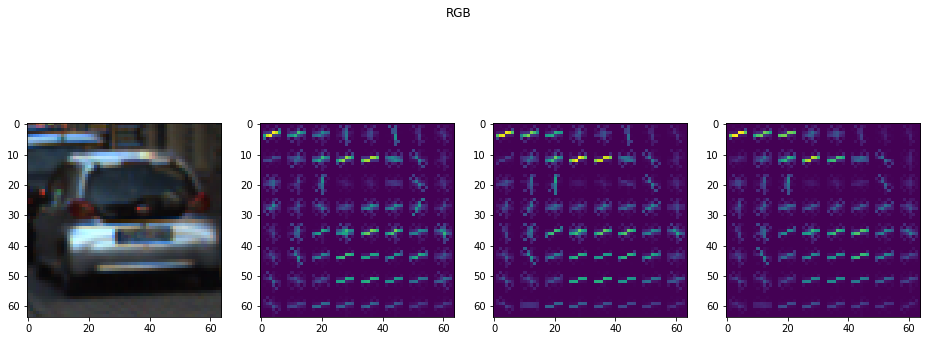

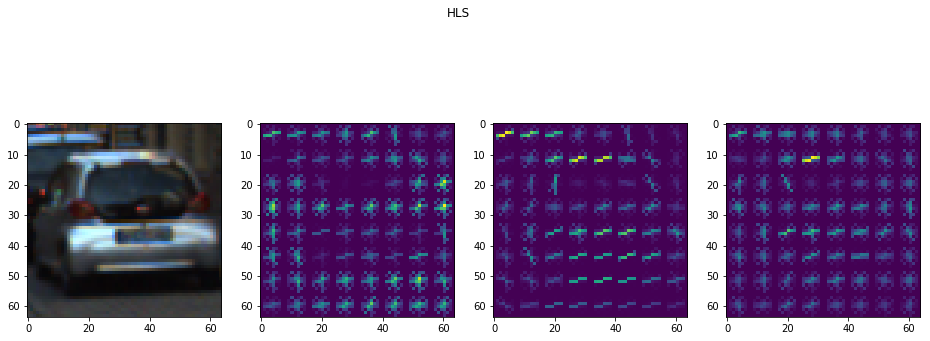

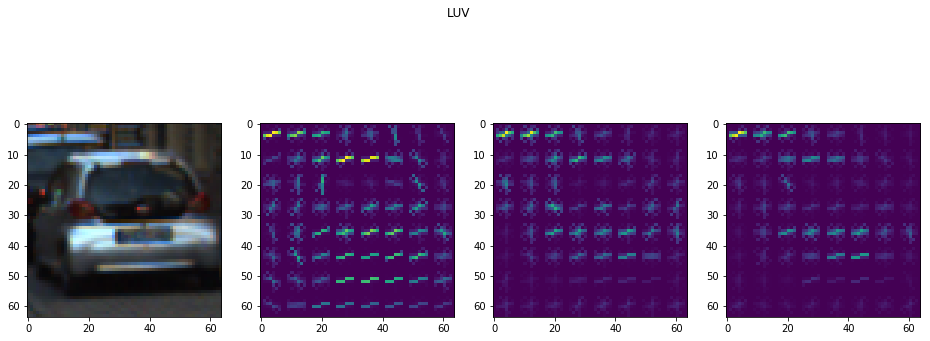

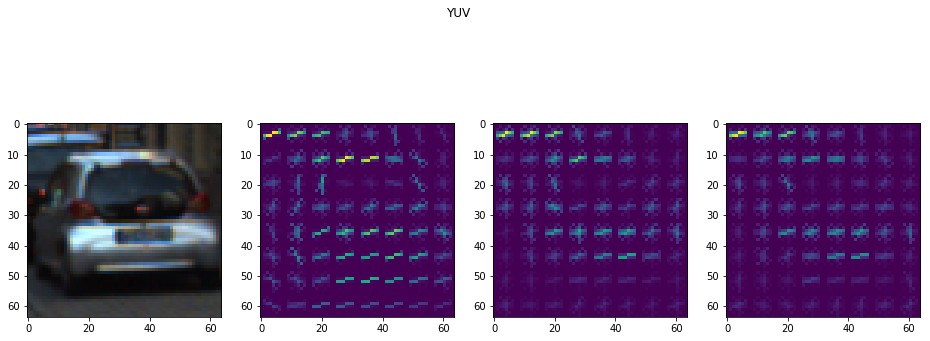

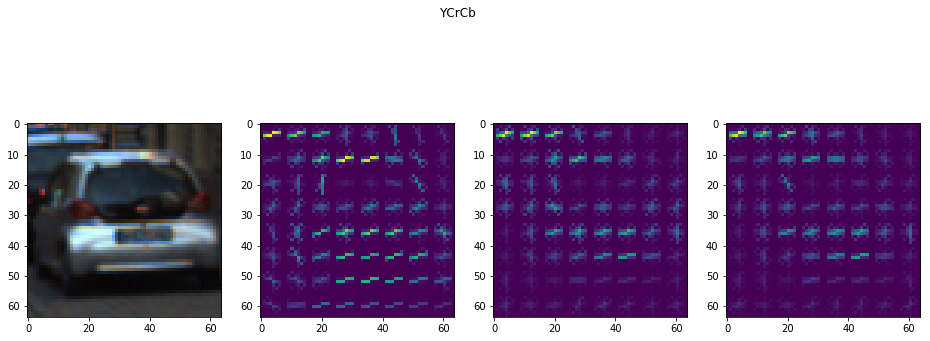

In [13]:
# Test the above function with a test image within a couple of color spaces
randImage = cv2.cvtColor(cv2.imread(train_imgs[randint(0, len(train_imgs))]), cv2.COLOR_BGR2RGB)

# Explore various color spaces for HOG gradient
color_spaces = ["RGB", "HLS", "LUV", "YUV", "YCrCb"]

for color_space in color_spaces:
    
    fig = plt.figure(figsize=(16,14))
    fig.suptitle(color_space)
    fig.add_subplot(3, 4, 1)
    plt.imshow(randImage)
    
    for channel in range(0, 3):
        fig.add_subplot(3, 4, 2 + channel)
        features, hog_image = get_hog_features(randImage, color_space=color_space, channel_index=channel, image=True)
        plt.imshow(hog_image)
    


While the above test shows slight differences, I'll be using YCrCb. The [wikipedia article](https://en.wikipedia.org/wiki/YCbCr) discusses how the Y channel encodes light, where as Cr and Cb hold the key information separate of brightness. To stay immune from brightness/darkness changing, YCrCb is a good choice.

I will also add that I tested a bunch of variations, and this is future-me coming back and saying I had the highest classification results with YCbCr versus doing the HOG on HSV or HLS. YUV showed promise as well, but YCbCr scored a single percentage point higher on classification.

Let's take a look at YCrCb with various parameters changing for the HOG function.

/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


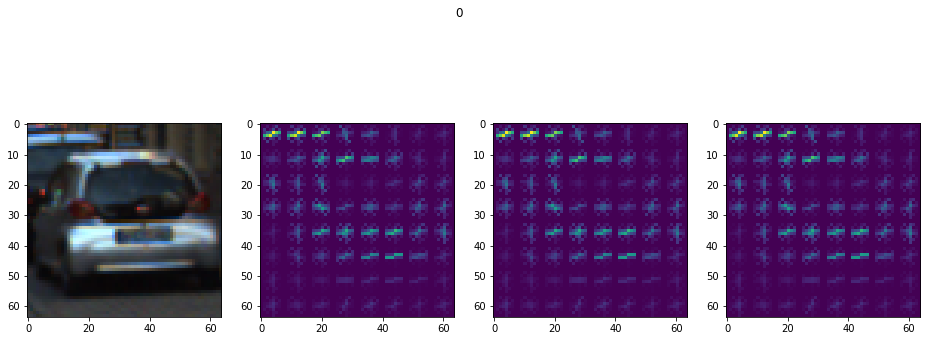

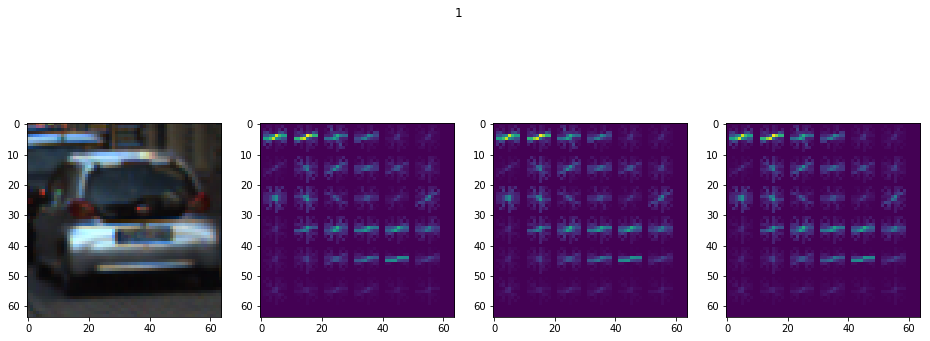

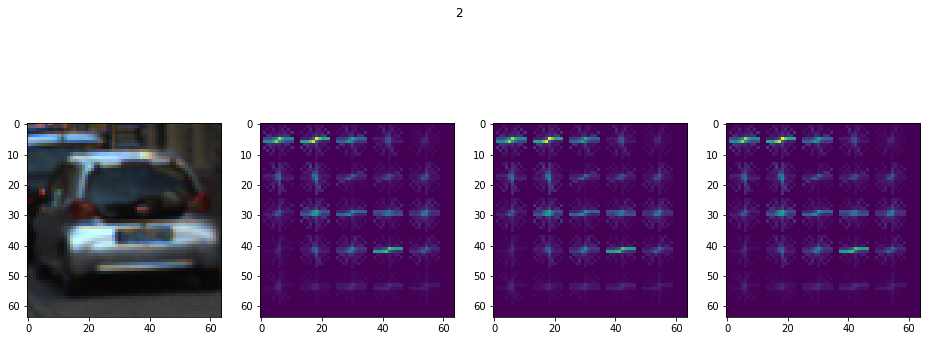

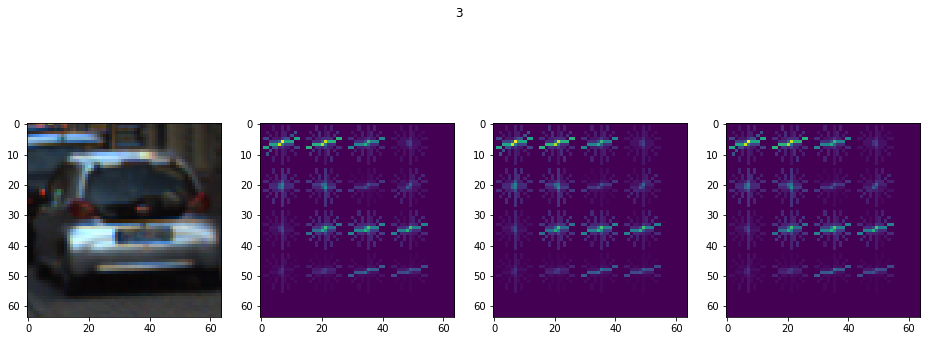

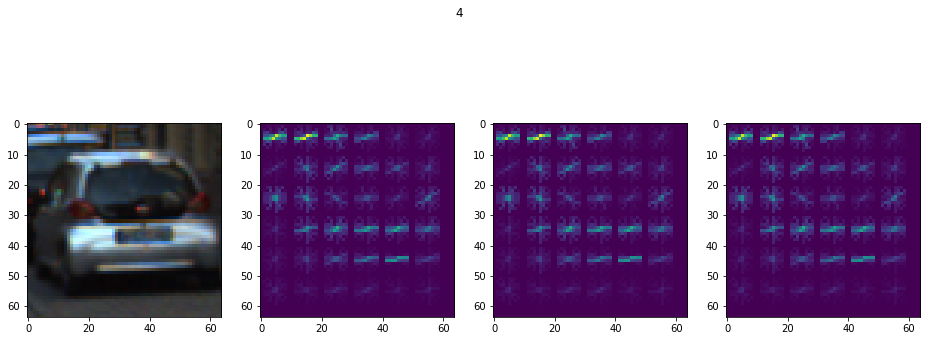

In [46]:
potential_settings = [
    { "orientations": 9, "pixels_per_cell": 8, "cells_per_block": 2 },
    { "orientations": 11, "pixels_per_cell": 10, "cells_per_block": 2 },
    { "orientations": 11, "pixels_per_cell": 12, "cells_per_block": 2 },
    { "orientations": 7, "pixels_per_cell": 14, "cells_per_block": 4 },
    { "orientations": 11, "pixels_per_cell": 10, "cells_per_block": 4 },
]


for index, setting in enumerate(potential_settings):
    
    fig = plt.figure(figsize=(16,14))
    fig.suptitle(index)
    fig.add_subplot(3, 4, 1)
    plt.imshow(randImage)
    
    for channel in range(0, 3):
        fig.add_subplot(3, 4, 2 + channel)
        features, hog_image = get_hog_features(randImage, color_space="YCrCb", channel_index=1, image=True,
                            orientations=setting["orientations"], pixels_per_cell=setting["pixels_per_cell"], cells_per_block=setting["cells_per_block"])
        plt.imshow(hog_image)
    

Above is just a sample of the different settings I played with. After trying a few dozen samples, I decided on `orientations=11`, `pixels_percell=10`, and `cells_per_block=4`. Note that some of the playing was with the classifier past this section as well - it really was trial and error. I didn't want pixels_per_cell to be too large or it seems like we're losing lots of data.

`cells_per_block` I originally thought I wanted to be low - it provides more data - but I ended up getting a lower classifier score with it.

## Build dataset

We can't load all the images into memory (well, maybe, but it's not a great idea) - but we can probably store the hog features map plus the spatially binned color channels that we want to pay attention too for each image for training.

We'll define two functions - one that, given a dataset, will maintain its order and generate the output for the dataset - `convert_dataset`. That will require something that will call and append the color binning (normalized) plus the hog features - we'll do that in `convert_sample`. Inside the `convert_sample` function, we'll be getting the color bin spatial features, getting the hog features (and raveling it), combining them, and then normalizing the sample to prevent any feature from overpowering the others.

We're also going to define numerous data augmentation functions that will modify the data a certain number of ways. This allows us to add the same image multiple times to our dataset, but make it different enough to not overfit the data. This makes a more robust classifier. Each augmentation was considered and limited to a scope that makes sense - IE no upside-down cars.

In [20]:
from sklearn.preprocessing import StandardScaler

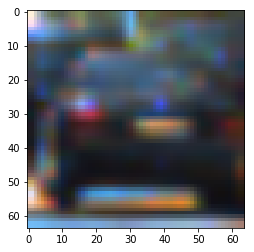

In [21]:
sample_image = cv2.cvtColor(cv2.imread(train_imgs[15]), cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)

In [22]:
import random

def random_rotation(img):
    rows,cols,_ = img.shape
    
    angle = random.uniform(-25.0, 25.0)

    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))


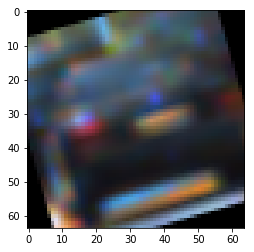

In [23]:
plt.imshow(random_rotation(sample_image))

In [24]:
def random_mirror(img):
    if random.randint(1, 2) is 2:
        return cv2.flip(img, 1)
    else:
        return img

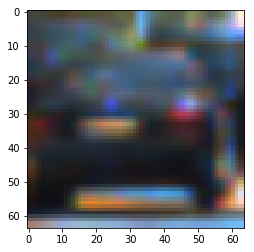

In [25]:
plt.imshow(random_mirror(sample_image))

In [26]:
def random_blur(img):
    blur_amount = random.randrange(1,10, 2)
    return cv2.GaussianBlur(img,(blur_amount,blur_amount),0)

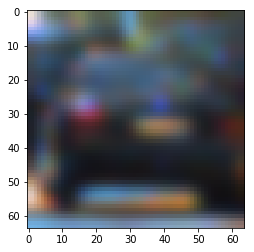

In [27]:
plt.imshow(random_blur(sample_image))

In [28]:
def random_brightness(img):
    if random.randint(1, 2) == 2:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(hsv)

        #Value is how much we change brightness by
        value = random.randint(50, 120)

        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value

        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
        return img
    else:
        how_dark = random.uniform(0.2, 0.7)
        black = np.zeros_like(img)
        return cv2.addWeighted(img, 1.0 - how_dark, black, how_dark, 0)

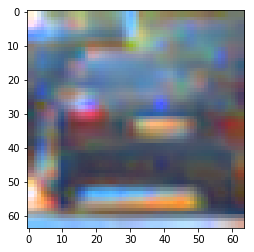

In [29]:
plt.imshow(random_brightness(sample_image))

In [30]:
def random_noise(img):
    row,col,ch = img.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)
    noise = np.ones_like(img)
    noise = noise * gauss
    noise = noise.astype(np.uint8)
    noise_level = random.uniform(0.1, 0.3)
    return cv2.addWeighted(img, 1 - noise_level, noise, noise_level, 0.0)

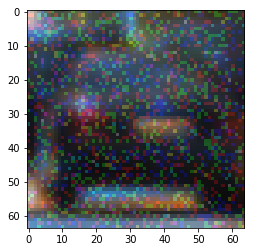

In [31]:
plt.imshow(random_noise(sample_image))

In [36]:
def random_augmentation(img):
    augmented = random_noise(img)
    augmented = random_brightness(augmented)
    augmented = random_blur(augmented)
    augmented = random_mirror(augmented)
#     augmented = random_rotation(augmented)
    return augmented

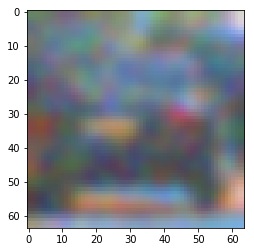

In [42]:
plt.imshow(random_augmentation(sample_image))

You'll note that I removed rotation. I got better results without it. I suspect that the classifier, being simple as it was, unlike CNNs that can deal with this, started associating black space left behind from the rotation to vehicles, resulting in worse overall results!

In [94]:
def convert_sample(img): 
    features = []
    color_bin_hs = color_bin_spatial(img, "HLS", channels_kept=["H", "S"])
    color_bin_v = color_bin_spatial(img, "HSV", channels_kept=["V"])
    features.append(color_bin_hs)
    features.append(color_bin_v)
    
    histogram_hs = histograms(img, color_space="HLS", channels_kept=["H", "S"])
    histogram_v = histograms(img, color_space="HSV", channels_kept=["V"])
    features.append(histogram_hs)
    features.append(histogram_v)
    
    #Use features we determined earlier
    for channel_index in range(0, 3):
        hog = get_hog_features(img, color_space="YCrCb", channel_index=channel_index, orientations=11, pixels_per_cell=10, cells_per_block=4)
        hog = hog.ravel()
        features.append(hog)
    
    #Append the two features
#     sample = [np.concatenate([color_bin, hog]).astype(np.float64)]
    sample = np.concatenate(features)
    
    return sample

In [95]:
print(len(train_imgs), len(test_imgs))

13320 4440


In [96]:
augmentations = 3

def convert_dataset(dataset, labels=None):
    converted = []
    converted_labels = []
    
    for index, data in enumerate(dataset):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        converted.append(convert_sample(img))
        
        if labels is not None:
            converted_labels.append(labels[index])

            for i in range(0, augmentations):
                augmented = random_augmentation(img)
                converted.append(convert_sample(augmented))
                converted_labels.append(labels[index])
        
    if labels is not None:
        return converted, converted_labels
    else:
        return converted

In [97]:
# train_features, train_labels = convert_dataset(train_imgs, labels=train_original_labels)
train_features = convert_dataset(train_imgs)
train_labels = train_original_labels
test_features = convert_dataset(test_imgs)

/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[  2.00000000e+01   6.20000000e+01   9.30000000e+01 ...,   3.66292690e-03
   1.63716156e-03   3.01844338e-03]


/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


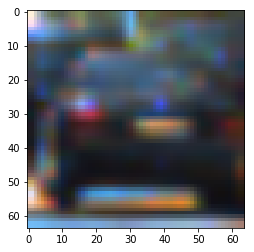

In [98]:
test = cv2.imread(train_imgs[15])
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(test)
result = convert_sample(test)
print(result)

In [99]:
print(len(train_features), len(train_labels), len(test_features), len(test_labels))

13320 13320 4440 4440


But wait - we didn't use the data augmentation! While I've had a lot of success in data augmentation with CNN's and deep learning, I was just getting way too many false positives from SVM classifiers with this augmented data. So I'll leave it in to show that I tried it, but alas - it did not work.

## Normalization

We are normalizing the data here to prevent any values with high value - say colors - to overpower things like gradient readings from the HOG. By normalizing, it ensures that only features that actually differentiate are used instead of homing in on arbitrality high values.

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

## Classifiers

Here we're looking at various classifiers and their accuracy on our dataset. We're looking at accuracy plus execution time - the time it takes to predict given a sample. If the execution time is too slow, we can't use it or our car won't react quick enough. If the accuracy is too low, it won't be worth using either.

In [101]:
from sklearn.svm import LinearSVC
from time import time

svc = LinearSVC()
# Check the training time for the SVC
t = time()
svc.fit(train_features, train_labels)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
t = time()
print('Test Accuracy of SVC = ', round(svc.score(test_features, test_labels), 4))
t2 = time()
print(round(t2-t, 2), 'Seconds to predict dataset')

2.62 Seconds to train SVC...
Test Accuracy of SVC =  0.9926
0.02 Seconds to predict dataset


In [102]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
t = time()
clf.fit(train_features, train_labels)
t2 = time()
print(round(t2-t, 2), 'Seconds to train Decision Tree...')
#Check score
t = time()
print('Test Accuracy of Decision Tree = ', round(clf.score(test_features, test_labels), 4))
t2 = time()
print(round(t2-t, 2), 'Seconds to predict dataset')

110.37 Seconds to train Decision Tree...
Test Accuracy of Decision Tree =  0.9721
0.03 Seconds to predict dataset


In [ ]:
from sklearn.svm import SVC
clf = SVC()
t = time()
clf.fit(train_features, train_labels)
t2 = time()
print(round(t2-t, 2), 'Seconds to Train SVC...')
#Check score
t = time()
print('Test Accuracy of SVC = ', round(clf.score(test_features, test_labels), 4))
t2 = time()
print(round(t2-t, 2), 'Seconds to predict dataset')

As we can see from above, the LinearSVC is fastest and most accurate of the classifiers The straight SVC took so long to train I had to stop it after over twenty minutes. and never got a result.

### Confusion Matrix

Below we calculate a quick confusion matrix from our predictions with the SVC. The Confusion Matrix shows us how many samples we predict to be a given label, versus how many WERE of the given label. It allows us to identify false positives and false negatives.

In [103]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(svc.predict(test_features), test_labels)

print(c_matrix)

[[2271   20]
 [  13 2136]]


As seen above, we have 70 false positives and 107 false negatives, so we are slightly more likely to declare something a vehicle than not. Here we were mostly checking to see if there was an extreme likelihood to not classify a vehicle or vice versa.

## Vehicle Classifier

This function's purpose is to take an image, resize it, convert it, and then normalize it for checking against the SVM - and then return the predicted results. Basically, a neat little helper function that ties together everything we built above.

I should note - inside here you'll see that I checked the prediction certainty of the sample and would reverse it if the certainty is below a certain threshold. I experimented with different values and whether or not to swap on a non vehicle identification - the accuracy plummeted no matter what I did here, so I left it be.

In [358]:
def vehicle_classifier(img):
    # First, resize the image to 64x64 - same size as the samples
    img = cv2.resize(img, (64,64))
    
    result = convert_sample(img)
    result = scaler.transform([result])
    
    prediction = svc.predict(result)[0]
    
#     prediction_certainty = svc.decision_function(result)[0]
# #     print(prediction_certainty)
#     if prediction_certainty <= 1.0 and prediction == "vehicle":
#         prediction = "nonvehicle"
#     elif prediction_certainty >= -3.0 and prediction == "nonvehicle":
#         prediction = "vehicle"
        
    
    return prediction

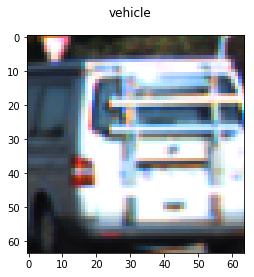

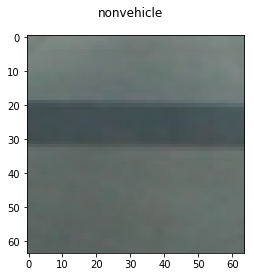

In [359]:
#Let's test an example of each a vehicle and non vehicle image
test = cv2.imread(train_imgs[12])
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

plt.figure()
plt.suptitle(vehicle_classifier(test))
plt.imshow(test)

test = cv2.imread(train_imgs[200])
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

plt.figure()
plt.suptitle(vehicle_classifier(test))
plt.imshow(test)

In [355]:
from sklearn.metrics import accuracy_score

# Checking accuracy when flopping on low confidence
t = time()
predictions = []
for img_filename in train_imgs:
    img = cv2.imread(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictions.append(vehicle_classifier(img))
t2 = time()
print("Took ", round(t2-t, 2), " seconds to predict entire dataset")

print(accuracy_score(predictions, train_original_labels))

Took  40.13  seconds to predict entire dataset
1.0


In [107]:
c_matrix = confusion_matrix(predictions, train_original_labels)

print(c_matrix)

[[6684    0]
 [   0 6636]]


In [356]:
from sklearn.metrics import accuracy_score

# Checking accuracy when flopping on low confidence
t = time()
predictions = []
for img_filename in test_imgs:
    img = cv2.imread(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictions.append(vehicle_classifier(img))
t2 = time()
print("Took ", round(t2-t, 2), " seconds to predict entire dataset")

print(accuracy_score(predictions, test_labels))

Took  13.4  seconds to predict entire dataset
0.992567567568


In [357]:
c_matrix = confusion_matrix(predictions, test_labels)

print(c_matrix)

[[2271   20]
 [  13 2136]]


Vehicle classifier is about 100% accurate on training (overfitting), and 99.25% on test, with more false negatives than positives now.

Note, commented out code above contained a threshold for certainty of prediction a-la `svc.prediction_function()`. I have commented that out as I did not see an overall improvement after experimentation with the below tests on data.

## Sliding Window Search

Now that we've got our classifier for vehicle/not vehicle, we need to iterate over the images in a controlled manner to grab samples that we'll check against the classifier.

First we're making the `sliding_windows` function, which generates windows coordinates (upper left, bottom right) within a given area of start/stop with a given overlap.

In [175]:
def sliding_windows(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop is not None:
        x_start_stop = list(x_start_stop)
    else:
        x_start_stop = [None, None]
        
    if y_start_stop is not None:
        y_start_stop = list(y_start_stop)
    else:
        y_start_stop = [None, None]

    if x_start_stop is None:
        x_start_stop = (0, img.shape[1])
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    
    if y_start_stop is None:
        y_start_stop = (0, img.shape[0])
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    yBuffer = np.int(xy_window[1]*(xy_overlap[1]))
    xBuffer = np.int(xy_window[0]*(xy_overlap[0]))
    nWindowsX = np.int((xspan - xBuffer)/nx_pix_per_step)
    nWindowsY = np.int((yspan - yBuffer)/ny_pix_per_step)

    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for yWindow in range(0, nWindowsY):
        for xWindow in range(0, nWindowsX):
            # Calculate each window position
            upperLeftY = (yWindow * ny_pix_per_step) + y_start_stop[0]
            upperLeftX = (xWindow * nx_pix_per_step) + x_start_stop[0]
            
            bottomRightY = upperLeftY + xy_window[1]
            bottomRightX = upperLeftX + xy_window[0]
            # Append window position to list
            window_list.append( ( (upperLeftX, upperLeftY), (bottomRightX, bottomRightY) ) )
    # Return the list of windows
    return window_list

In [113]:
#Tester for the above function
def test_sliding_windows(x_start_stop, y_start_stop, xy_window, xy_overlap):
    img =  cv2.imread("./test_images/test6.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    windows = sliding_windows(img, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)


    for window in windows:
        cv2.rectangle(img, window[0], window[1], (0, 0, 255), 6)


    plt.imshow(img)

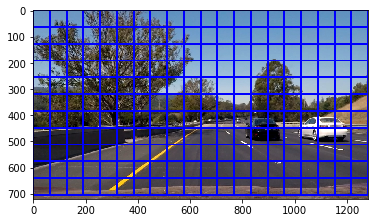

In [114]:
# Test the above function out
test_sliding_windows((None, None), (None, None), (128, 128), (0.5, 0.5))

## Identify Regions of Interest + Sizes

Now that we've got `sliding_windows` written, we need to select areas we're going to run the sliding window search on - and what sizes we're going to do them with. The idea is that "small" car matches will always come from the horizion, and "large" car matches should only come from nearby - and the sky shouldn't have any cars yet.

This is mostly trial and area to define the regions. Below are the results of the trial and error

In [115]:
tiny_horizon = { "x_start_stop": None, "y_start_stop": (370, 550), "xy_window": (64,64), "xy_overlap": (0.5, 0.5) }

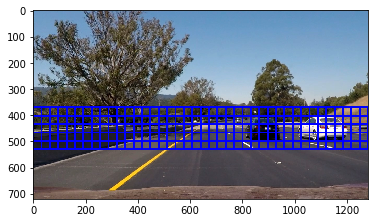

In [116]:
test_sliding_windows(tiny_horizon["x_start_stop"], tiny_horizon["y_start_stop"], tiny_horizon["xy_window"], tiny_horizon["xy_overlap"])

In [117]:
ahead_small = { "x_start_stop": None, "y_start_stop": (370, 550), "xy_window": (96,96), "xy_overlap": (0.8, 0.8) }

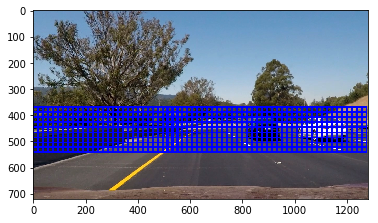

In [118]:
test_sliding_windows(ahead_small["x_start_stop"], ahead_small["y_start_stop"], ahead_small["xy_window"], ahead_small["xy_overlap"])

In [119]:
ahead_large = { "x_start_stop": None, "y_start_stop": (370, 625), "xy_window": (128,128), "xy_overlap": (0.8, 0.8) }

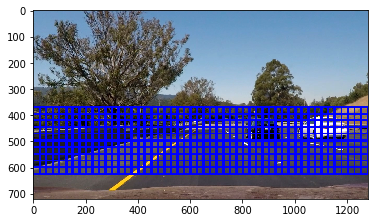

In [120]:
test_sliding_windows(ahead_large["x_start_stop"], ahead_large["y_start_stop"], ahead_large["xy_window"], ahead_large["xy_overlap"])

In [121]:
close_large = { "x_start_stop": None, "y_start_stop": (370, 625), "xy_window": (196,196), "xy_overlap": (0.75, 0.75) }

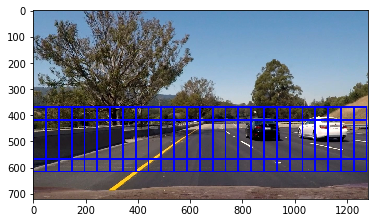

In [122]:
test_sliding_windows(close_large["x_start_stop"], close_large["y_start_stop"], close_large["xy_window"], close_large["xy_overlap"])

Above we created a couple of ranges that we want to scan. We're going to put the ranges together, and then scan each sliding window, checking the output of each with `vehicle_classifier`.

In [362]:
ranges = [tiny_horizon, ahead_small, ahead_large, close_large]

In [422]:
def scan_ranges(img):
    
    car_detections = []
    
    for area in ranges:
        windows = sliding_windows(img, x_start_stop=area["x_start_stop"], y_start_stop=area["y_start_stop"], 
                    xy_window=area["xy_window"], xy_overlap=area["xy_overlap"])
        
        for window in windows:
            roi = img[ window[0][1] : window[1][1] , window[0][0] : window[1][0] ]
            classification = vehicle_classifier(roi)
            
            if classification == "vehicle":
                car_detections.append(window)
                
    return car_detections

In [125]:
def draw_scanned_ranges(img, positive_windows, draw=True):
    for window in positive_windows:
        cv2.rectangle(img, window[0], window[1], (0, 0, 255), 6)
    
    if draw is True:
        plt.figure()
        plt.imshow(img)
        plt.show()
    else:
        return img

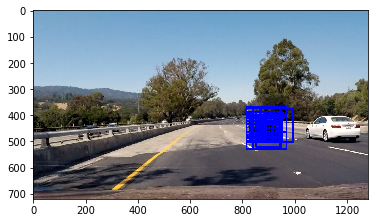

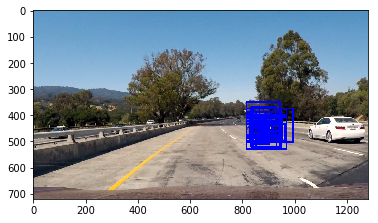

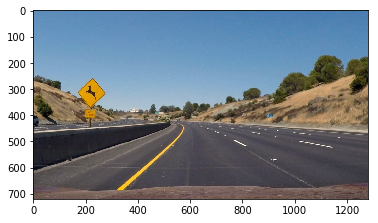

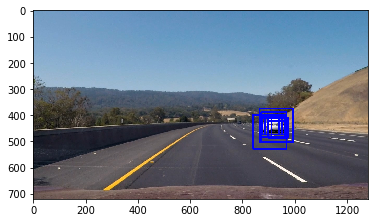

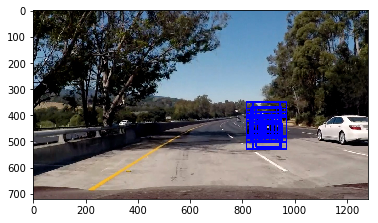

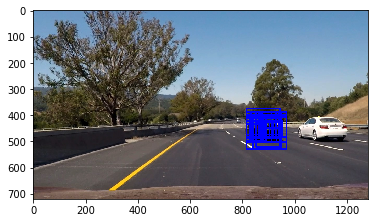

In [354]:
from glob import glob

test_images = glob("./test_images/*.jpg")

for test_image in test_images:
    img =  cv2.imread(test_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    car_detections = scan_ranges(img)
    draw_scanned_ranges(img, car_detections)

The initial test looks good with some false positives and thankfully no false negatives in the test images. Hopefully the false positives will go away once we do a heatmap of detection

## Multiple Detections, False Positives, and Heatmaps

Above we have an example of all of both multiple detections of a singular vehicle and false positive results (no vehicle present). We're going to try and deal with these by creating a heatmap of detections.

When we create the heatmap, we essentially take a map of zeros and add to a pixel's value for each sliding window that covers it. We then threshold this map, taking only pixels that have a value over a certain threshold - this ensures that multiple detections and not one-off false positives are selected.

With the heatmap, we use scipy's `labels` [function](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html) and `nonzero` [function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html) to identify and isolate bounding boxes from the resulting heatmap blobs 

In [135]:
def create_heatmap(img, detections):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    for detection in detections:
        heatmap[ detection[0][1]:detection[1][1] , detection[0][0]:detection[1][0] ] += 1
        
    return heatmap

In [136]:
def apply_heatmap_threshold(heatmap, threshold):
    heatmap_threshold = np.copy(heatmap)
    heatmap_threshold[ heatmap_threshold <= threshold ] = 0
    return heatmap_threshold

In [137]:
def bounding_boxes_from_heatmap(heatmap):
    #We need to do some work to convert the simple heatmaps into something that the blob detector can use.
    heatmap_8bit = np.copy(heatmap)
    heatmap_8bit *= 50
    heatmap_8bit = heatmap_8bit.astype(np.uint8)
    
    params = cv2.SimpleBlobDetector_Params()
    params.filterByInertia = False
    params.filterByConvexity = False
    detector = cv2.SimpleBlobDetector_create(params)
    
    return detector.detect(heatmap_8bit)

In [138]:
from scipy.ndimage.measurements import label

def bounding_boxes_from_heatmap(heatmap):
    labels, number_of_features = label(heatmap)
    
    bounding_boxes = []
    
    for feature_number in range(1, number_of_features + 1):
        # Find all items in the heatmap that map to a specific value/label
        nonzero = (labels == feature_number).nonzero()
        # The nonzero function returns a the (y,x) coords of where non zero functions exist
        # Since we isolated the value of the car we're looking at, we can work from there!
        x = np.array(nonzero[1])
        y = np.array(nonzero[0])
        
        bbox = ( (np.min(x), np.min(y)), (np.max(x), np.max(y)) )
        
        bounding_boxes.append(bbox)
        
    return bounding_boxes

/home/keith/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


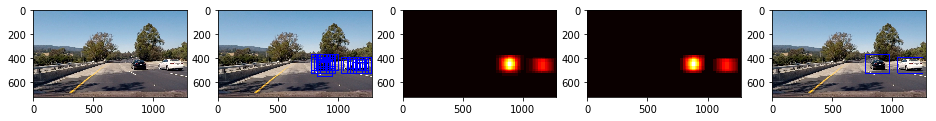

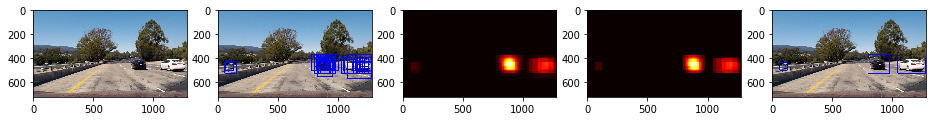

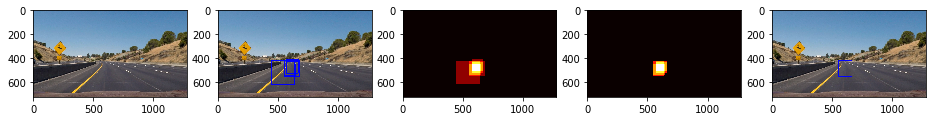

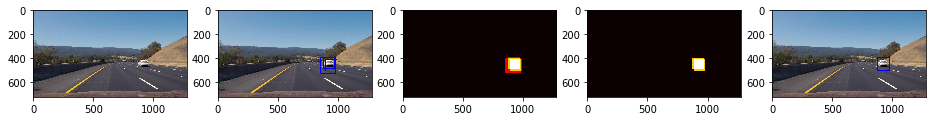

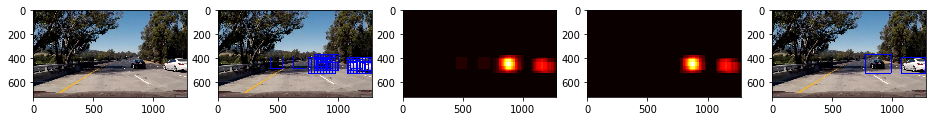

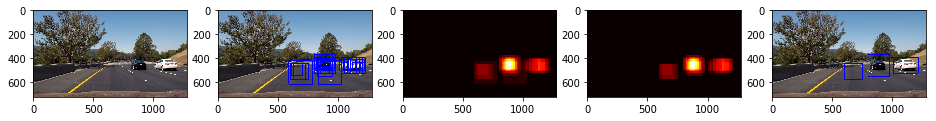

In [139]:
from glob import glob

test_images = glob("./test_images/*.jpg")

threshold = 1

heatmaps = []

for test_image in test_images:
    img =  cv2.imread(test_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_marked = img.copy()
    
    car_detections = scan_ranges(img)
    heatmap = create_heatmap(img, car_detections)
    heatmap_thresholded = apply_heatmap_threshold(heatmap, threshold)
    
    heatmaps.append(heatmap_thresholded)
    
    bounding_boxes = bounding_boxes_from_heatmap(heatmap_thresholded)
    for box in bounding_boxes:
        cv2.rectangle(img_marked, box[0], box[1], (0, 0, 255), 6)
        
    
    fig = plt.figure(figsize=(16,14))
    fig.add_subplot(2, 5, 1)
    plt.imshow(img)
    fig.add_subplot(2, 5, 2)
    plt.imshow(draw_scanned_ranges(img, car_detections, draw=False))
    fig.add_subplot(2, 5, 3)
    plt.imshow(heatmap, cmap='hot')
    fig.add_subplot(2, 5, 4)
    plt.imshow(heatmap_thresholded, cmap='hot')
    fig.add_subplot(2, 5, 5)
    plt.imshow(img_marked)
    
    

Above, we see a demonstration of each step of the process. Given an image, we

1. Run a sliding window scan across, passing each subsection to the classifier for detection.
2. Use the detected windows to add value to a zero-mask of the image.
3. Create a thresholded mask from teh heatmap
4. Using that resulting thresholded heatmap, detect individual blobs for vehicles
5. Mark those as cars

## Handling Video Footage

Let's load up some video handling libraries, and see how our pipeline works on two provided videos - `test_video.mp4` and `project_video.mp4`

In [140]:
# Imports
from moviepy.editor import VideoFileClip

In [364]:
#Output video based on what we have

def test_process_frame(img):    
    car_detections = scan_ranges(img)
    heatmap = create_heatmap(img, car_detections)
    heatmap_thresholded = apply_heatmap_threshold(heatmap, threshold)
    
    bounding_boxes = bounding_boxes_from_heatmap(heatmap_thresholded)
    
    for box in bounding_boxes:
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
        
    return img

test_clip = VideoFileClip("./test_video.mp4")
output_clip = test_clip.fl_image(test_process_frame)
%time output_clip.write_videofile("./output_images/test_video_no_memory.mp4", audio=False)

pv_clip = VideoFileClip("./project_video.mp4")
output_clip = pv_clip.fl_image(test_process_frame)
%time output_clip.write_videofile("./output_images/project_video_no_memory.mp4", audio=False)

[MoviePy] >>>> Building video ./output_images/test_video_no_memory.mp4
[MoviePy] Writing video ./output_images/test_video_no_memory.mp4



 97%|█████████▋| 38/39 [01:24<00:02,  2.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_no_memory.mp4 

CPU times: user 1min 24s, sys: 91.7 ms, total: 1min 24s
Wall time: 1min 24s
[MoviePy] >>>> Building video ./output_images/project_video_no_memory.mp4
[MoviePy] Writing video ./output_images/project_video_no_memory.mp4



 24%|██▍       | 303/1261 [11:10<35:34,  2.23s/it]


 48%|████▊     | 605/1261 [22:24<23:38,  2.16s/it]


 72%|███████▏  | 907/1261 [33:33<13:08,  2.23s/it]


 96%|█████████▌| 1205/1261 [44:35<02:04,  2.23s/it]


100%|█████████▉| 1260/1261 [46:39<00:02,  2.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_no_memory.mp4 

CPU times: user 46min 35s, sys: 1.98 s, total: 46min 37s
Wall time: 46min 39s


Observing the outputs generated above - `test_video_no_memory.mp4` and `project_video_no_memory.mp4`, both in the `output_images` directory - we can see that while we do detect the cars, the results are bouncy and somewhat unreliable. If we introduce a form of memory - that tracks cars frame to frame - we can probably make a far smoother tracking system. That's what we'll attack next.

## Building a Car Class

We are going to build a "car" class object to make it easier track a car's existence frame to frame. This will make organizing the code easier, and allow us to identify and track a car throughout a video's processing. 

The car object tracks the current "age" of the car by frame count. It also tracks prior bounding boxes, its time last seen (so we know when we probably lost the car and can kill it safely), and has numerous helper functions that handle the drawing of the boundary boxes for the car.


### Pipeline With Car Class

Each frame starts with calling `tick` on each car. This reset each car for the frame, incrementing their age and removing their current bounding box (but remembering it if referenced).

We then scan over every car that has been seen recently relative to its age. If it has been seen recently, we perform a sliding window scan over a range over the car itself - this is designed to double check over a certain area for where we last saw the car to find that car again.

We then (or at least, every 5 frames), do a more standard scan over the ranges we defined earlier. Whenever we we get a potential window, we first see if it overlaps or is close enough to another car that we should count it as a read of the car we already know about. If not, we generate a new "car" object. This doesn't necessarily mean it gets drawn - for that to occur, it has to be seen a certain # of times within a certain age limit (and not be killed due to lack of detection) over several frames to be seen.

We `tock` each car - this calculates if a car should be seen still, where it's bounding box should be, and more. We then check if we should kill any cars that haven't been seen/detected in awhile.

We also check to see if cars should be combined at this stage - in the even of occluison, or if two "car" readings get too close to eachother that they should be counted together.

Finally, we have each car that should be seen draw its own bounding box.

In [144]:
cars = []

In [421]:
class Car:
    
    def __init__(self, bounding_box = None):
        global cars
        
        self.name = "Car-" + str(len(cars) + 1)
        
        #Bounding box information
        self.bounding_box = bounding_box #This is the current bounding box
        self.speed = 0
        
        #Hold prior information about the car
        self.prior_bounding_boxes = []
        
        # Hold this car's age in frames
        self.age = 1
        # last_seen is what relative frame the car was last seen
        self.last_seen = 1
        
        # self.seen is whether or not a bounding box was observed during processing this frame
        self.seen = False
        
        # draw is whether or not the bounding box should be drawn
        self.draw = self.bounding_box is not None
        
    # Overlap detection - given a bounding box, determine if this overlaps to warrant it being
    # the same vehicle
    # returns true or false
    def overlap(self, bounding_box):
        current_box = self.bounding_box if self.bounding_box is not None else self.prior_bounding_boxes[-1]

        car_left =  current_box[0][0]
        car_right = current_box[1][0]
        car_top = current_box[0][1]
        car_bot = current_box[1][1]
        
        bbox_left = bounding_box[0][0]
        bbox_right = bounding_box[1][0]
        bbox_top = bounding_box[0][1]
        bbox_bot = bounding_box[1][0]
        
        left = max(car_left, bbox_left)
        right = min(car_right, bbox_right)
        bottom = min(car_bot, bbox_bot)
        top = max(car_top, bbox_top)
        
        return left < right and bottom > top
    
    
    # Nearby will take a look at the provided bounding box and determine if it's near enough to warrant it
    # being considered the same vehicle
    # returns true or false
    def nearby(self, bounding_box):
        
        # distance is the minimum distance in pixels to be considered part of the car
        distance = 20
        
        new_bounding_box = [ (bounding_box[0][0] - 20, bounding_box[0][1] - 20), (bounding_box[1][0] + 20, bounding_box[1][1] + 20) ]
        
        return self.overlap(new_bounding_box)
                
    # should_combine is a true/false function that says whether or not the bounding boxes should be combined
    # uses both overlap and nearby functions
    def should_combine(self, bounding_box):
        return self.overlap(bounding_box) or self.nearby(bounding_box)
    
    # combine is a function that, given a current bounding_box and the car's current,
    # shall recalculate the current bounding box based on magnitude (size) of bounding boxes
    def combine(self, bounding_box):
        # If there is no bounding box, this BECOMES the bounding box
        if self.bounding_box is None:
            if len(self.prior_bounding_boxes) >= 1:
                self.bounding_box = self.prior_bounding_boxes[-1]
                self.combine(bounding_box)
            else:
                self.bounding_box = bounding_box
        else:
            # We're going to keep changes to 10% of the change to prevent jitteriness
            left_x_diff = (bounding_box[0][0] - self.bounding_box[0][0]) * .1
            left_y_diff = (bounding_box[0][1] - self.bounding_box[0][1]) * .1
            right_x_diff = (bounding_box[1][0] - self.bounding_box[1][0]) * .1
            right_y_diff = (bounding_box[1][1] - self.bounding_box[1][1]) * .1

            left_x = int(self.bounding_box[0][0] + left_x_diff)
            left_y = int(self.bounding_box[0][1] + left_y_diff)
            right_x = int(self.bounding_box[1][0] + right_x_diff)
            right_y = int(self.bounding_box[1][1] + right_y_diff) 
            
            self.bounding_box = ( (left_x, left_y), (right_x, right_y) )
    
    # Should_die is a function that returns true/false on whether the car hasn't been seen in a long enough time
    # that it should be considered "dead" and forgotten. Metal.
    def should_die(self):
        if self.age < 32:
            return False # If we're young, we can't die
        
        #Otherwise follow the rules
        return self.age - self.last_seen >= 10
    
    def draw_bounding_box(self, img):
        box = self.bounding_box if self.bounding_box is not None else self.prior_bounding_boxes[-1]        
        cv2.rectangle(img, box[0], box[1], (0, 255, 0), 6)
        
    # returns if the frame is old enough to be seen
    def old_enough(self):
        return self.age >= 32 and len(self.prior_bounding_boxes) >= 25
    
    def generate_ranges(self, frame):
        current_ranges = []
        
        #First, build a range the size of the current bounding box, + 10pixels for margin
        current_box = self.bounding_box if self.bounding_box is not None else self.prior_bounding_boxes[-1]
        
        current_box = ( (max(current_box[0][0] - 10, 0), max(current_box[0][1] - 10, 0)),
                        (min(current_box[1][0] + 10, frame.shape[1]), min(current_box[1][1] + 10, frame.shape[0])) )
        
        x_start_stop = (max(current_box[0][0] - 50, 0), min(current_box[1][0] + 50, frame.shape[1]))
        y_start_stop = (max(current_box[0][1] - 50, 0), min(current_box[1][1] + 50, frame.shape[0]))
        
        current_ranges.append({ "x_start_stop": x_start_stop, "y_start_stop": y_start_stop,\
                       "xy_window": (max(current_box[1][0] - current_box[0][0] - 32, 128), max(current_box[1][1] - current_box[0][1] - 32, 128)),\
                       "xy_overlap": (0.8, 0.8) })
        
        current_ranges.append({ "x_start_stop": x_start_stop, "y_start_stop": y_start_stop,\
                       "xy_window": (128, 128),\
                       "xy_overlap": (0.8, 0.8) })
        
        current_ranges.append({ "x_start_stop": x_start_stop, "y_start_stop": y_start_stop,\
                       "xy_window": (96, 96),\
                       "xy_overlap": (0.8, 0.8) })
        
        current_ranges.append({ "x_start_stop": x_start_stop, "y_start_stop": y_start_stop,\
               "xy_window": (64, 64),\
               "xy_overlap": (0.8, 0.8) })
        
        return current_ranges
        
    
    def scan_ranges(self, frame):
        car_detections = []
    
        for area in self.generate_ranges(frame):
            windows = sliding_windows(img, x_start_stop=area["x_start_stop"], y_start_stop=area["y_start_stop"], 
                        xy_window=area["xy_window"], xy_overlap=area["xy_overlap"])

            for window in windows:
                roi = frame[ window[0][1] : window[1][1] , window[0][0] : window[1][0] ]
                classification = vehicle_classifier(roi)

                if classification == "vehicle":
                    car_detections.append(window)

        return car_detections
    
    #scan over car performs sliding window scans over a car itself
    def scan_over_car(self, frame, debug=False):
        car_detections = self.scan_ranges(frame)
        heatmap = create_heatmap(frame, car_detections)
        threshold = 5
        heatmap_thresholded = apply_heatmap_threshold(heatmap, threshold)
        bounding_boxes = bounding_boxes_from_heatmap(heatmap_thresholded)
        
        if debug:
            plt.figure()
            plt.suptitle("Heatmap")
            plt.imshow(heatmap, cmap="hot")
            plt.figure()
            plt.suptitle("Heatmap Thresholded")
            plt.imshow(heatmap_thresholded, cmap="hot")
            
            plt.figure()
            plt.suptitle("Bounding Boxes from Heatmap")
            canvas = frame.copy()
            for bbox in bounding_boxes:
                cv2.rectangle(canvas, bbox[0], bbox[1], (0, 0, 255), 3)

            plt.imshow(canvas)
        
        if len(bounding_boxes) is 0:
            return
        
        for bbox in bounding_boxes:
            self.combine(bbox)
        
    # Tick advances time for each car tracker.
    def tick(self):
        self.age += 1
        
        if self.bounding_box is not None:
            self.prior_bounding_boxes.append(self.bounding_box)

        self.bounding_box = None
        self.seen = False
    
    # Tock is called after tick, after all processing 
    def tock(self):
        if self.bounding_box is None:
            # We don't see this car anymore - don't increment last_seen!
            # this is me not doing that thing
            
            # Calculate whether we should be "seen"
            self.seen = not self.should_die() and self.old_enough()
            
        else:
            # We see this car, so increment it's last_seen
            self.last_seen = self.age
            
            # Set seen if we're old enough and we have enough prior frames of info
            self.seen = self.old_enough()
            

Let's play around with the sliding window convolutional search around the car and see what that's like. Below are trial and error runs (showing the final results) of setting up a sliding window convolutional search around each car.

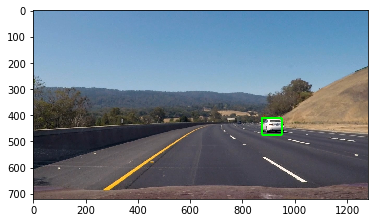

In [294]:
test_image = cv2.cvtColor(cv2.imread("./test_images/test3.jpg"), cv2.COLOR_BGR2RGB)

#Initial car positioning
test_image_write = test_image.copy()
car_init = [ (875, 410), (950, 475) ]
car = Car(car_init)
car.draw_bounding_box(test_image_write)
plt.figure()
plt.imshow(test_image_write)

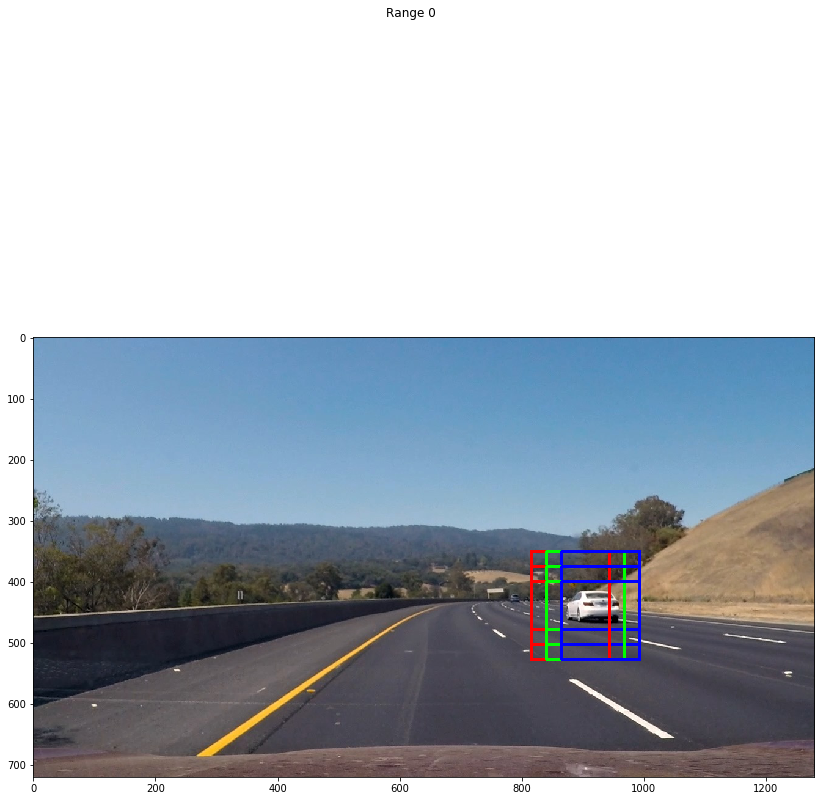

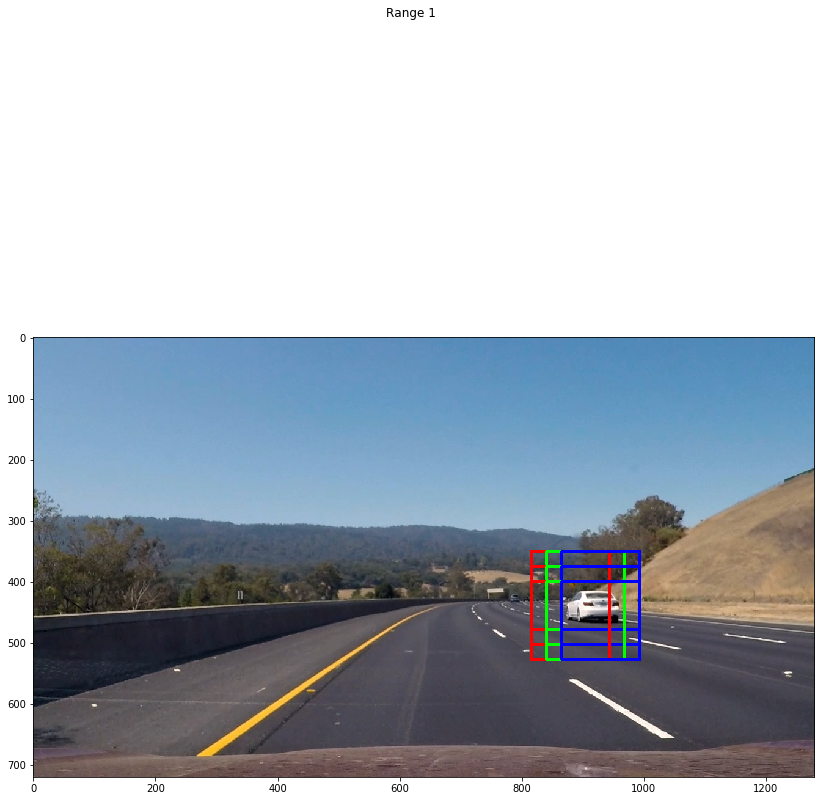

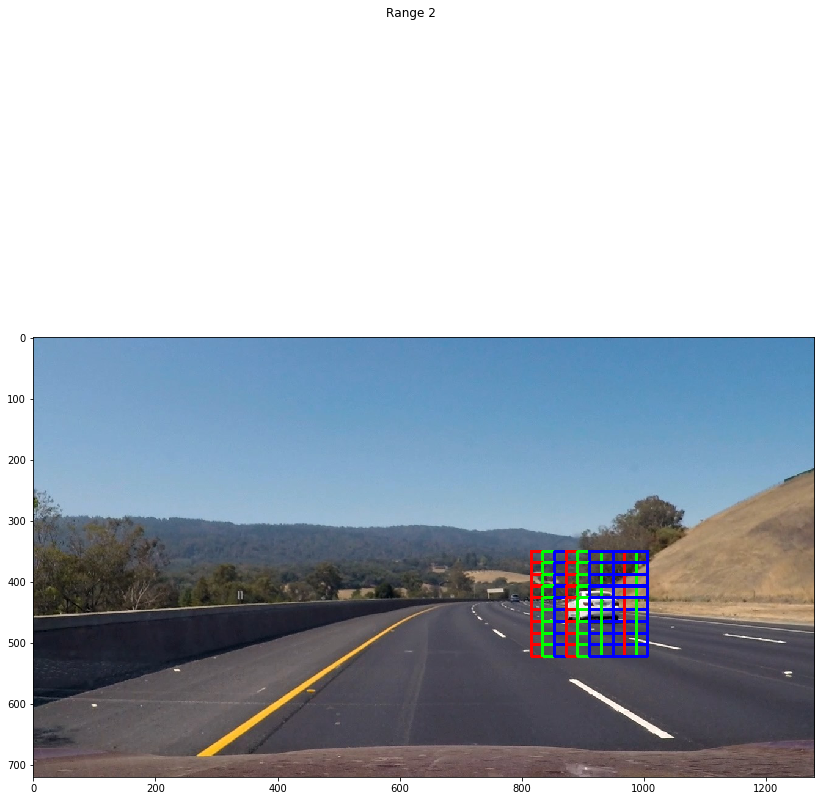

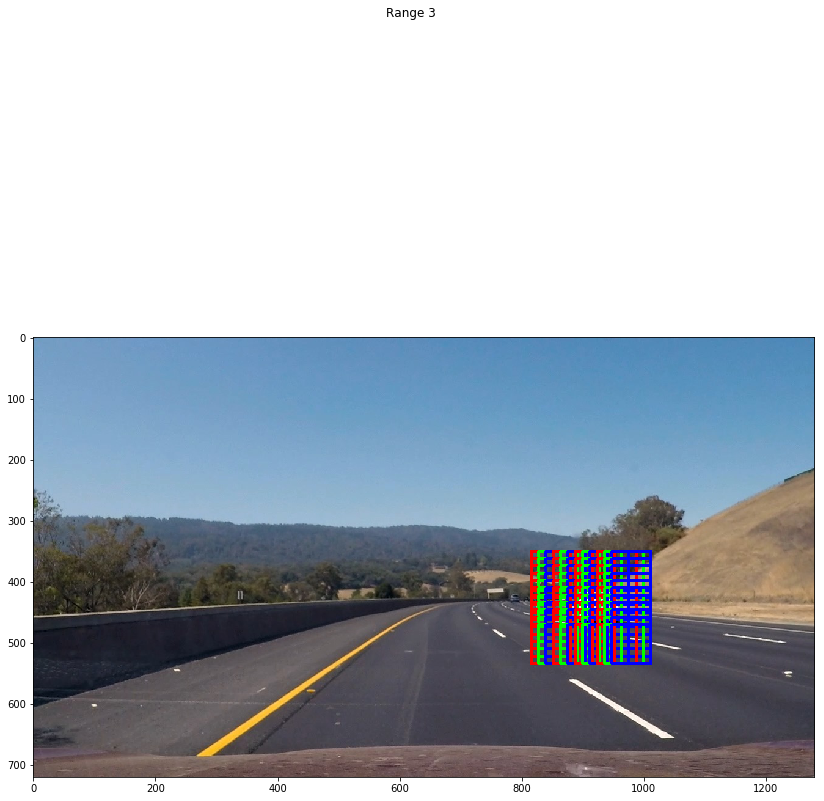

In [295]:
test_ranges = car.generate_ranges(test_image)

for index, area in enumerate(test_ranges):
    test_image_scan = test_image.copy()
    
    windows = sliding_windows(test_image_scan, x_start_stop=area["x_start_stop"], y_start_stop=area["y_start_stop"], 
                        xy_window=area["xy_window"], xy_overlap=area["xy_overlap"])

    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = 0
    for window in windows:
        color = colors[color_index]
        color_index += 1
        if color_index >= len(colors):
            color_index = 0
            
        cv2.rectangle(test_image_scan, window[0], window[1], color, 3)
        
    plt.figure(figsize=(14,16))
    plt.suptitle("Range " + str(index))
    plt.imshow(test_image_scan)
    plt.show()

19  detections


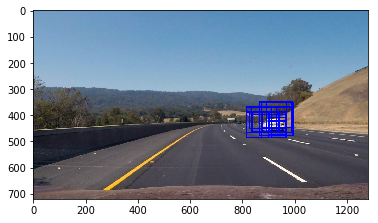

In [297]:
detections = car.scan_ranges(test_image)

test_image_detects = test_image.copy()

print(len(detections), " detections")

for detection in detections:
    cv2.rectangle(test_image_detects, detection[0], detection[1], (0, 0, 255), 3)
    
plt.imshow(test_image_detects)

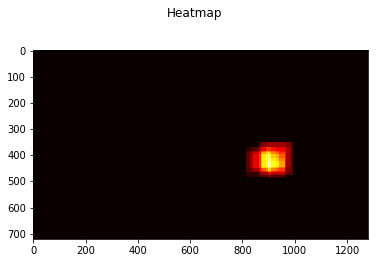

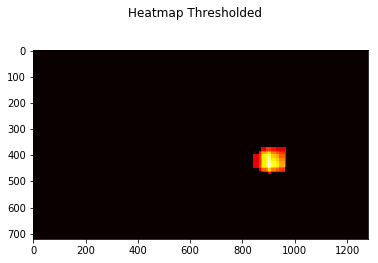

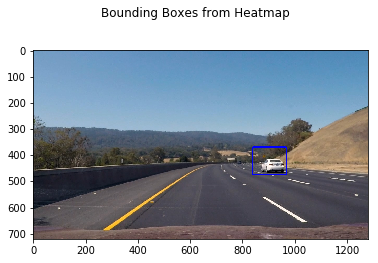

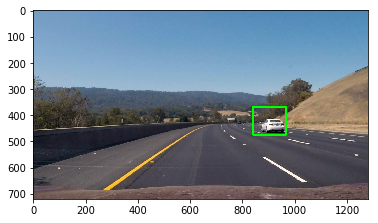

In [298]:
# This test is testing the result of the heatmap scan and playing with the threshold
scan_test = test_image.copy()

car.scan_over_car(scan_test, debug=True)

car.draw_bounding_box(scan_test)

plt.figure()
plt.imshow(scan_test)

Above are tests where I tested and expanded settings for the `scan_over_car` function - specifically its scanner, the ranges being provided, results, and heatmap and thresholding.

The idea is that I would scan over known cars every frame (unlike full window scanning) but require a higher thresholding over the car as I have way more detections.

In [420]:
cars = []
frame_count = 0

def pipeline(frame):
    global cars
    global frame_count
    
    frame_count += 1
    
    # Go through every car and initiate the "tick" - start of processing step
    for car in cars:
        car.tick()
        
    # For each car, do a scan of just that car - but only if its old enough to be seen
    # within its agespan
    for car in cars:
        car.scan_over_car(frame)
        
    # Only scan everything 5th frame
    if frame_count % 5 == 0:
        # Go through the frame image, and produce the detection windows
        car_detections = scan_ranges(frame)
        heatmap = create_heatmap(frame, car_detections)
        heatmap_threshold = apply_heatmap_threshold(heatmap, threshold)
        bounding_boxes = bounding_boxes_from_heatmap(heatmap_threshold)
        
        for box in bounding_boxes:
            # For every box, let's see if it should be combined with current cars
            used = False
            for car in cars:
                if car.should_combine(box):
                    car.combine(box)
                    used = True
                    break
            if not used:
                car = Car(box)
                cars.append(car)
            
    #Now that we've created / updated all cars, tock them
    for car in cars:
        car.tock()
    
    # Remove cars that should die post tock
    # not efficient, but I was just trying to do this quickly. forgive me.
    for car in list(cars): #use list() to create a copy so we can remove while iterating
        if car.should_die():
            cars.remove(car)
    
    # If the cars overlap, produce a singular larger box
    for car in cars:
        if car.seen is False:
            continue
            
        for check_car in cars:
            if check_car.name == car.name:
                continue
            elif check_car.seen is False:
                continue
            else:
                current_box = car.bounding_box if car.bounding_box is not None else car.prior_bounding_boxes[-1]
                if current_box is None:
                    continue
                if check_car.should_combine(current_box):
                    check_car.seen = False
                    
                    car_box = car.bounding_box if car.bounding_box is not None else car.prior_bounding_boxes[-1]
                    check_box = check_car.bounding_box if check_car.bounding_box is not None else check_car.prior_bounding_boxes[-1]
                    
                    car_left_x = min(car_box[0][0], check_box[0][0])
                    car_left_y = min(car_box[0][1], check_box[0][1])
                    car_right_x = max(car_box[1][0], check_box[1][0])
                    car_right_y = max(car_box[1][1], check_box[1][1])
                    
                    car.bounding_box = [ (car_left_x, car_left_y), (car_right_x, car_right_y) ]
        
    # Draw a bounding box for each car now if it should be drawn
    for car in cars:
        if car.seen:
            car.draw_bounding_box(frame)

    #Return the drawn frame!
    return frame
        

In [418]:
cars = []
pv_clip = VideoFileClip("./project_video.mp4")
output_clip = pv_clip.fl_image(pipeline)
%time output_clip.write_videofile("./output_images/project_video.mp4", audio=False)

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4



 13%|█▎        | 158/1261 [04:00<48:18,  2.63s/it]


 24%|██▍       | 307/1261 [12:00<31:27,  1.98s/it]


 36%|███▌      | 457/1261 [18:01<23:08,  1.73s/it]


 48%|████▊     | 608/1261 [22:52<36:43,  3.37s/it]


 60%|██████    | 759/1261 [30:11<53:08,  6.35s/it]


 72%|███████▏  | 910/1261 [43:37<32:41,  5.59s/it]


 84%|████████▍ | 1060/1261 [56:40<30:57,  9.24s/it]


 95%|█████████▌| 1204/1261 [1:11:41<05:03,  5.33s/it]


100%|█████████▉| 1260/1261 [1:16:22<00:04,  4.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 

CPU times: user 1h 16min 21s, sys: 1.49 s, total: 1h 16min 22s
Wall time: 1h 16min 22s


## Results, Problems, and Improvements

The above results worked out great! It took a lot of trial and error to find a classifier that was successful on the white car in the bright area. The classifier saw several revisions, trying to get from ~94% > 99% accuracy, and then to pass test results on that troublesome white car. You can see the issues when the bounding box on the car hones in on only the tail of the car - the front of it is simply not getting identified due to a lack of distinguishable features from the all the white.

We did have one brief false positive in center lane - that could be solved by a different classifier or having a longer "minimum age" for a "car" to be identified. It does die off quickly, however.

Still, there are numerous improvements that we can perform in order to improve the accuracy and reliabilty of our detection system.

The largest problem is our time to process - since we sometimes scan large portions of the image *on top of* scanning over each individual car, we can have individual frames that take some time to do scanning. This can be solved by 

1. Not scanning the whole scene as often
2. Not scanning the cars as often
3. Killing "unseen" cars more often, preventing the large amount of small area scans.

Obviously, switching to C/C++ would also speed up detection speed. Likewise, a "smart" pipeline that could be speed-aware could change its scanning times and srategies based on our speed, what road we're on, or what vehicles it detects.

### Other Classifiers

I stayed with the pure computer vision and svm approach as that was the design of the lesson. Within this notebook, you can see some experimentations with various classifiers from the sklearn framewokr. I was tempted several times, however, to use previously taught deep learning techniques. This was backed by several discussions with other students in the program's slack who utilized deep learning for their own projects.

I could have used a convolutional neural network (CNN) and trained it on my provided dataset. If I started with something similar to a LeNet architecture, I would have a very good set of feature detectors already built into the earlier convolutional layers.

There are two ways I could have used the CNN. The first is the most obvious - train it to act as a classifier that I could swap into my current code base. This would take the sliding window reads and then classify as vehicle/nonvehicle, and work from there.

Another method discussed in Slack that I thought was clever was to train it against only a few sample images hand-made from the provided videos (instead of the suggested classification dataset), then during training routinely check the network in a NN visualizer. Once we see one of the layers lighting up in response to cars, we can take the value of that layer/filter directly. If overlayed over the image, you'd see cars generally light up - we could then blob detect/use scipy's `labels` on that to build up bounding boxes.

Other architectures were discussed, such as an RCNN or SSD or retraining a YOLO architecture network in order to get a multi-detection network running.


### Advanced Improvements

If we could pair this project with a multiple lane detection pipeline, we could then define a better search range - afterall, most cars are in lane. With this we could determine car speeds and build a local map of lanes and car's lane positions relative to our own car. This would be neccessary for more complex navigation and car movement - such as changing lanes or prepping for an oncoming turn.

Another great improvement would be to identify guardrails, yellow lane lines, and other lane dividers. Once we identify lane divisions clearly, we can safely begin to ignore areas that we don't need to detect vehicles. IE I don't care what cars *over* the guardrails are doing in nearly all cases.